In [9]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import matplotlib.pyplot as plt
import numpy as np

from rdkit import Chem
from rdkit.Chem import Draw
from tqdm import tqdm
import math
import xgboost
import xgboost as xgb
import pickle
import duckdb

In [10]:
from binding_prediction.const import WHOLE_MOLECULE_COLUMN, TARGET_COLUMN

from binding_prediction.datasets.xgboost_iterator import SmilesIterator

from binding_prediction.evaluation.kaggle_submission_creation import get_submission_test_predictions


# EDA

## Get train dataset info

In [3]:
train_path = 'data/train.parquet'
test_path = 'data/test.parquet'

In [3]:
parquet_file = pq.ParquetFile('data/train.parquet')

In [4]:
parquet_file.metadata

  created_by: parquet-cpp-arrow version 14.0.2
  num_columns: 7
  num_rows: 295246830
  num_row_groups: 282
  format_version: 2.6
  serialized_size: 291416

In [5]:
row_group_0 = parquet_file.read_row_group(0)
row_group_1 = parquet_file.read_row_group(1)

combined_table = pa.concat_tables([row_group_0, row_group_1])
pq.write_table(row_group_0, 'data/row_group_0.parquet')
pq.write_table(combined_table, 'data/two_row_groups.parquet')


In [10]:
for i in range(parquet_file.metadata.num_row_groups):
    row_group_stats = parquet_file.metadata.row_group(i).column(0).statistics
    print(f"row group: {i}, num of rows: {row_group_stats.num_values}")

row group: 0, num of rows: 1048576
row group: 1, num of rows: 1048576
row group: 2, num of rows: 1048576
row group: 3, num of rows: 1048576
row group: 4, num of rows: 1048576
row group: 5, num of rows: 1048576
row group: 6, num of rows: 1048576
row group: 7, num of rows: 1048576
row group: 8, num of rows: 1048576
row group: 9, num of rows: 1048576
row group: 10, num of rows: 1048576
row group: 11, num of rows: 1048576
row group: 12, num of rows: 1048576
row group: 13, num of rows: 1048576
row group: 14, num of rows: 1048576
row group: 15, num of rows: 1048576
row group: 16, num of rows: 1048576
row group: 17, num of rows: 1048576
row group: 18, num of rows: 1048576
row group: 19, num of rows: 1048576
row group: 20, num of rows: 1048576
row group: 21, num of rows: 1048576
row group: 22, num of rows: 1048576
row group: 23, num of rows: 1048576
row group: 24, num of rows: 1048576
row group: 25, num of rows: 1048576
row group: 26, num of rows: 1048576
row group: 27, num of rows: 1048576
ro

### Create subsample of train dataset to experiment with it

In [15]:
# https://www.kaggle.com/code/andrewdblevins/leash-tutorial-ecfps-and-random-forest
con = duckdb.connect()

df = con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT 20000000)
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT 1589906)""").df()
pq.write_table(pa.Table.from_pandas(df), 'data/subsampled_20M_train.parquet')

con.close()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

OutOfMemoryException: Out of Memory Error: failed to pin block of size 256.0 KiB (25.6 GiB/25.5 GiB used)

In [11]:
row_group_df = parquet_file.read_row_group(0).to_pandas()
row_group_df.to_csv('data/row_group_0.csv')

In [12]:
row_group_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 7 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   id                     1048576 non-null  int64 
 1   buildingblock1_smiles  1048576 non-null  object
 2   buildingblock2_smiles  1048576 non-null  object
 3   buildingblock3_smiles  1048576 non-null  object
 4   molecule_smiles        1048576 non-null  object
 5   protein_name           1048576 non-null  object
 6   binds                  1048576 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 56.0+ MB


### Get statistics of the target column

In [15]:
negative_count = 0
positive_count = 0
for i in range(parquet_file.metadata.num_row_groups):
    row_group_df = parquet_file.read_row_group(i).to_pandas()
    negative_count += row_group_df[TARGET_COLUMN].value_counts()[0]
    positive_count += row_group_df[TARGET_COLUMN].value_counts()[1]
    print(f"row group: {i}, negative count: {negative_count}, positive count: {positive_count}")

row group: 0, negative count: 1045893, positive count: 2683
row group: 1, negative count: 2092545, positive count: 4607
row group: 2, negative count: 3140583, positive count: 5145
row group: 3, negative count: 4186941, positive count: 7363
row group: 4, negative count: 5232376, positive count: 10504
row group: 5, negative count: 6280195, positive count: 11261
row group: 6, negative count: 7326609, positive count: 13423
row group: 7, negative count: 8371545, positive count: 17063
row group: 8, negative count: 9417021, positive count: 20163
row group: 9, negative count: 10462505, positive count: 23255
row group: 10, negative count: 11508339, positive count: 25997
row group: 11, negative count: 12554987, positive count: 27925
row group: 12, negative count: 13595529, positive count: 35959
row group: 13, negative count: 14637106, positive count: 42958
row group: 14, negative count: 15683876, positive count: 44764
row group: 15, negative count: 16722203, positive count: 55013
row group: 16, 

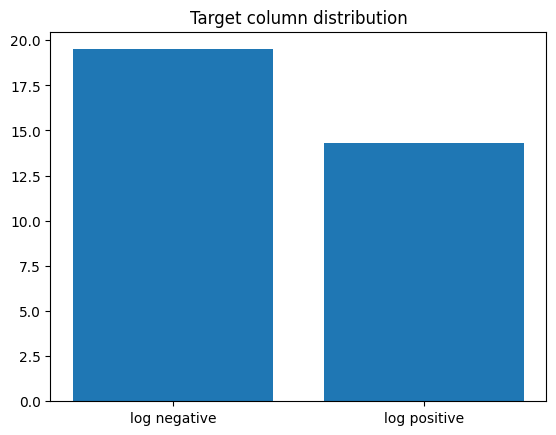

In [20]:
_ = plt.bar(['log negative', 'log positive'], [np.log(negative_count), np.log(positive_count)])
_ = plt.title('Target column distribution')

### Draw couple of molecules

In [22]:
row_group_df = parquet_file.read_row_group(0).to_pandas()

In [24]:
row_group_df[WHOLE_MOLECULE_COLUMN].head()

0    C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...
1    C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...
2    C#CCOc1ccc(CNc2nc(NCC3CCCN3c3cccnn3)nc(N[C@@H]...
3    C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...
4    C#CCOc1ccc(CNc2nc(NCc3cccc(Br)n3)nc(N[C@@H](CC...
Name: molecule_smiles, dtype: object

In [36]:
smiles = []
targets = []
for i in tqdm(range(parquet_file.metadata.num_row_groups)):
    row_group_df = parquet_file.read_row_group(i).to_pandas()
    negative_sample = row_group_df[row_group_df[TARGET_COLUMN] == 0].sample(2)
    positive_sample = row_group_df[row_group_df[TARGET_COLUMN] == 1].sample(2)
    subsample = pd.concat([negative_sample, positive_sample])
    smiles.extend(subsample[WHOLE_MOLECULE_COLUMN].values)
    targets.extend(subsample[TARGET_COLUMN].values)

100%|█████████████████████████████████| 282/282 [02:32<00:00,  1.85it/s]


100%|█████████████████████████████████| 100/100 [00:01<00:00, 77.90it/s]


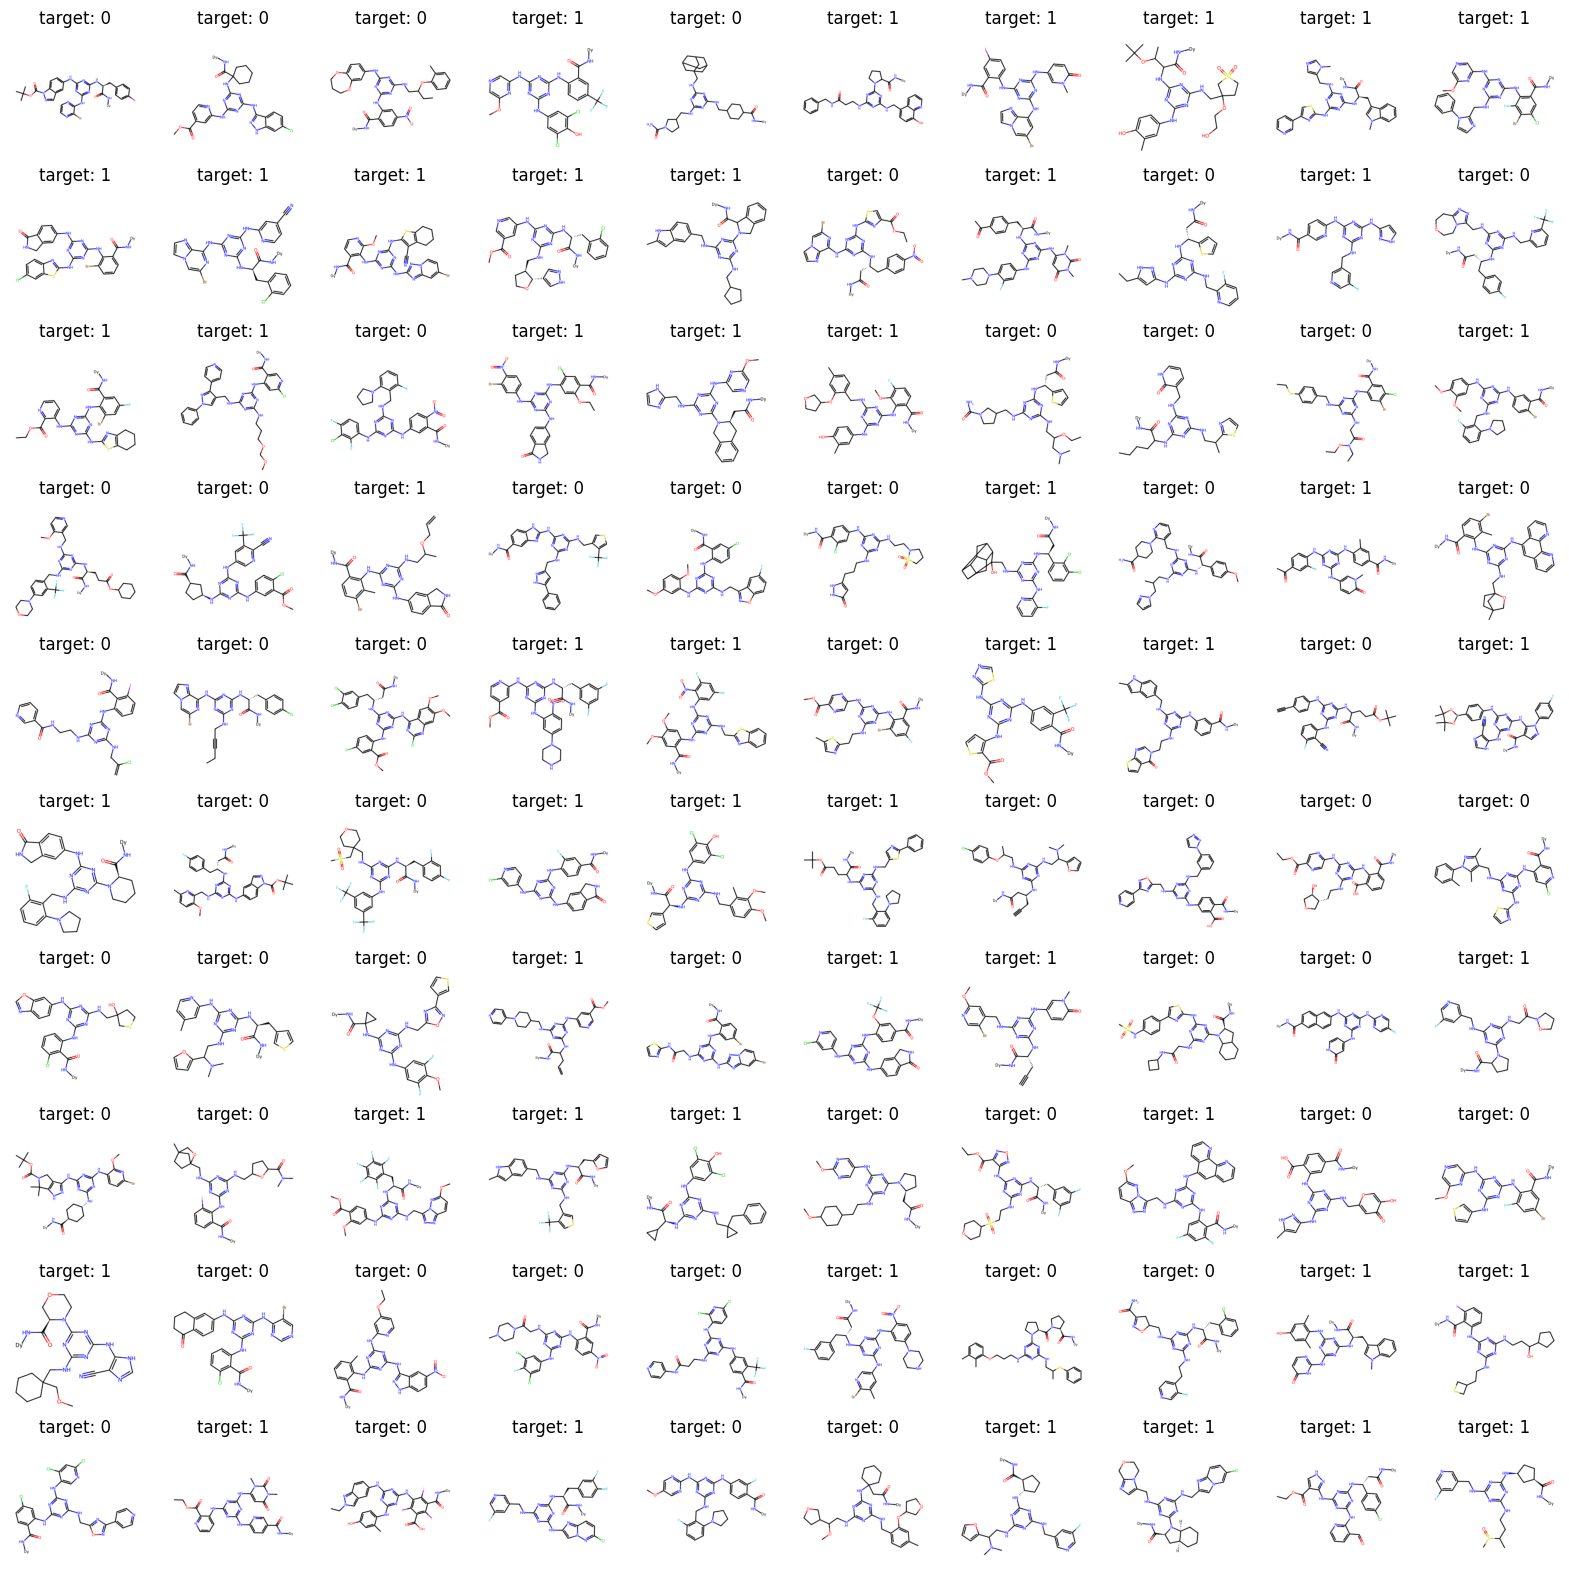

In [37]:
num_mols_to_draw = 100
random_indices = np.random.choice(len(smiles), num_mols_to_draw, replace=False)
grid_size = math.ceil(np.sqrt(num_mols_to_draw))
fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))
for i in tqdm(range(num_mols_to_draw)):
    smile = smiles[random_indices[i]]
    target = targets[random_indices[i]]
    mol = Chem.MolFromSmiles(smile)
    ax = axs[i // grid_size, i % grid_size]
    ax.imshow(Draw.MolToImage(mol))
    ax.set_title(f'target: {target}')
ax.axis('off')

# XGBoost baseline

In [11]:
print('Train validation split')
train_file_path = 'data/row_group_0.parquet'
rng = np.random.default_rng(seed=42)

train_val_pq = pq.ParquetFile(train_file_path)
train_indices = rng.choice(train_val_pq.metadata.num_rows, int(0.8 * train_val_pq.metadata.num_rows), replace=False)
val_indices = np.setdiff1d(np.arange(train_val_pq.metadata.num_rows), train_indices)

print('Creating datasets')
train_dataset = SmilesIterator(train_file_path, indicies=train_indices, radius=3, test_set=False)
val_dataset = SmilesIterator(train_file_path, indicies=val_indices, radius=3, test_set=False)
test_dataset = SmilesIterator('data/test.parquet', shuffle=False, radius=3, test_set=True)

Train validation split
Creating datasets


In [5]:
train_Xy = xgboost.DMatrix(train_dataset)

Reading row group 0
Reading time 26.255187034606934


In [6]:
val_Xy = xgboost.DMatrix(val_dataset)

Reading row group 0
Reading time 23.34353804588318


In [12]:
test_Xy = xgboost.DMatrix(test_dataset)

Reading row group 0
Reading time 38.00017285346985
Reading row group 1
Reading time 30.79599404335022


In [13]:
print('Load model')
model_path = 'logs/2024-04-25_22-04-59/model.pkl'
with open(model_path, 'rb') as file:
    model = pickle.load(file)
    

Load model


In [14]:
print('Predicting')
get_submission_test_predictions(test_dataset, test_Xy, model, 'logs/2024-04-25_22-04-59')

Predicting
Testing model time: 162.78501868247986
Saving predictions


/Users/Alisa.Alenicheva/Documents/hackathons/belka/binding_prediction/binding_prediction/evaluation/kaggle_submission_creation.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  submission = pd.concat([submission,


Saving predictions time: 4.5320093631744385


In [8]:
print('Creating model')
params = {
    'max_depth': 10,
    'objective': 'binary:logistic',
    # 'nthread': 4,
    'eval_metric': 'auc',
    'verbosity': 2
}


num_rounds = 10  # equivalent to the number of estimators

eval_list = [(train_Xy, 'train'), (val_Xy, 'eval')]  # evaluation set for monitoring

Creating model


In [ ]:
model = xgb.train(params, train_Xy, num_rounds, evals=eval_list, verbose_eval=100000)

[16:50:33] INFO: /Users/runner/work/xgboost/xgboost/src/data/./sparse_page_dmatrix.h:147: Make cache:./cache-0x7feddb021710.gradient_index.page

[16:51:56] INFO: /Users/runner/work/xgboost/xgboost/src/data/./sparse_page_dmatrix.h:147: Make cache:./cache-0x7feddb021710.gradient_index.page

[16:51:56] INFO: /Users/runner/work/xgboost/xgboost/src/data/sparse_page_dmatrix.cc:176: Generating new Gradient Index.


In [ ]:
# Save the model using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)